# **Data Cleaning Notebook**

## Objectives

- Identify and assess missing values in the dataset
- Handle missing data through imputation or removal
- Prepare a clean dataset for modeling and further analysis

## Inputs

- outputs/datasets/collection/HousePrices.csv

## Outputs

- Cleaned full dataset: outputs/datasets/cleaned/HousePricesCleaned.csv
- Cleaned train/test splits: outputs/datasets/cleaned/TrainSetCleaned.csv, outputs/datasets/cleaned/TestSetCleaned.csv
- Data cleaning pipeline: outputs/ml_pipeline/data_cleaning/dataCleaning_pipeline.pkl


---

# Change working directory

In [1]:
import os

current_dir = os.getcwd()
os.chdir(os.path.dirname(current_dir))  # set project root
print("Current directory:", os.getcwd())

Current directory: /workspaces/heritage-housing


---

## Load Collected Data

In [2]:
import pandas as pd

df = pd.read_csv("outputs/datasets/collection/HousePrices.csv")
df.head(5)

,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtExposure,BsmtFinSF1,BsmtFinType1,BsmtUnfSF,EnclosedPorch,GarageArea,GarageFinish,...,LotFrontage,MasVnrArea,OpenPorchSF,OverallCond,OverallQual,TotalBsmtSF,WoodDeckSF,YearBuilt,YearRemodAdd,SalePrice
0,856,854.0,3.0,No,706,GLQ,150,0.0,548,RFn,...,65.0,196.0,61,5,7,856,0.0,2003,2003,208500
1,1262,0.0,3.0,Gd,978,ALQ,284,NaN,460,RFn,...,80.0,0.0,0,8,6,1262,NaN,1976,1976,181500
2,920,866.0,3.0,Mn,486,GLQ,434,0.0,608,RFn,...,68.0,162.0,42,5,7,920,NaN,2001,2002,223500
3,961,NaN,NaN,No,216,ALQ,540,NaN,642,Unf,...,60.0,0.0,35,5,7,756,NaN,1915,1970,140000
4,1145,NaN,4.0,Av,655,GLQ,490,0.0,836,RFn,...,84.0,350.0,84,5,8,1145,NaN,2000,2000,250000


---

## Data Exploration

In Data Cleaning you are interested to check the distribution and shape of a variable with missing data.

In [3]:
vars_with_missing_data = df.columns[df.isna().sum() > 0].to_list()
vars_with_missing_data

['2ndFlrSF',
 'BedroomAbvGr',
 'BsmtExposure',
 'BsmtFinType1',
 'EnclosedPorch',
 'GarageFinish',
 'GarageYrBlt',
 'LotFrontage',
 'MasVnrArea',
 'WoodDeckSF']

In [4]:
from ydata_profiling import ProfileReport

if vars_with_missing_data:
    profile = ProfileReport(df=df[vars_with_missing_data], minimal=True)
    profile.to_notebook_iframe()
else:
    print("There are no variables with missing data")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

---

## Correlation and PPS Analysis

In [5]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ppscore as pps
import warnings

warnings.filterwarnings("ignore")

def heatmap_corr(df, threshold, figsize=(20, 12), font_annot=8):
    if len(df.columns) > 1:
        mask = np.zeros_like(df, dtype=bool)
        mask[np.triu_indices_from(mask)] = True
        mask[abs(df) < threshold] = True

        fig, axes = plt.subplots(figsize=figsize)
        sns.heatmap(
            df,
            annot=True,
            xticklabels=True,
            yticklabels=True,
            mask=mask,
            cmap="viridis",
            annot_kws={"size": font_annot},
            ax=axes,
            linewidth=0.5,
        )
        axes.set_yticklabels(df.columns, rotation=0)
        plt.ylim(len(df.columns), 0)
        plt.show()


def heatmap_pps(df, threshold, figsize=(20, 12), font_annot=8):
    if len(df.columns) > 1:
        mask = np.zeros_like(df, dtype=bool)
        mask[abs(df) < threshold] = True
        fig, ax = plt.subplots(figsize=figsize)
        ax = sns.heatmap(
            df,
            annot=True,
            xticklabels=True,
            yticklabels=True,
            mask=mask,
            cmap="rocket_r",
            annot_kws={"size": font_annot},
            linewidth=0.05,
            linecolor="grey",
        )
        plt.ylim(len(df.columns), 0)
        plt.show()


def CalculateCorrAndPPS(df):
    df_corr_spearman = df.corr(method="spearman", numeric_only=True)
    df_corr_pearson = df.corr(method="pearson", numeric_only=True)

    pps_matrix_raw = pps.matrix(df)
    pps_matrix = pps_matrix_raw.filter(["x", "y", "ppscore"]).pivot(
        columns="x", index="y", values="ppscore"
    )

    pps_score_stats = (
        pps_matrix_raw.query("ppscore < 1").filter(["ppscore"]).describe().T
    )
    print("PPS threshold - check PPS score IQR to decide threshold for heatmap \n")
    print(pps_score_stats.round(3))

    return df_corr_pearson, df_corr_spearman, pps_matrix


def DisplayCorrAndPPS(
    df_corr_pearson,
    df_corr_spearman,
    pps_matrix,
    CorrThreshold,
    PPS_Threshold,
    figsize=(20, 12),
    font_annot=8,
):

    print("\n")
    print(
        "* Analyse how the target variable for your ML models are correlated with other variables (features and target)"
    )
    print(
        "* Analyse multi-colinearity, that is, how the features are correlated among themselves"
    )

    print("\n")
    print("*** Heatmap: Spearman Correlation ***")
    print("It evaluates monotonic relationship \n")
    heatmap_corr(
        df=df_corr_spearman,
        threshold=CorrThreshold,
        figsize=figsize,
        font_annot=font_annot,
    )

    print("\n")
    print("*** Heatmap: Pearson Correlation ***")
    print("It evaluates the linear relationship between two continuous variables \n")
    heatmap_corr(
        df=df_corr_pearson,
        threshold=CorrThreshold,
        figsize=figsize,
        font_annot=font_annot,
    )

    print("\n")
    print("*** Heatmap: Power Predictive Score (PPS) ***")
    print(
        f"PPS detects linear or non-linear relationships between two columns.\n"
        f"The score ranges from 0 (no predictive power) to 1 (perfect predictive power) \n"
    )
    heatmap_pps(
        df=pps_matrix, threshold=PPS_Threshold, figsize=figsize, font_annot=font_annot
    )

Calculate Correlations and Power Predictive Score.

In [6]:
df_corr_pearson, df_corr_spearman, pps_matrix = CalculateCorrAndPPS(df)

PPS threshold - check PPS score IQR to decide threshold for heatmap 

         count   mean    std  min  25%  50%   75%    max
ppscore  552.0  0.055  0.104  0.0  0.0  0.0  0.06  0.702


Display at Heatmaps



* Analyse how the target variable for your ML models are correlated with other variables (features and target)
* Analyse multi-colinearity, that is, how the features are correlated among themselves


*** Heatmap: Spearman Correlation ***
It evaluates monotonic relationship 



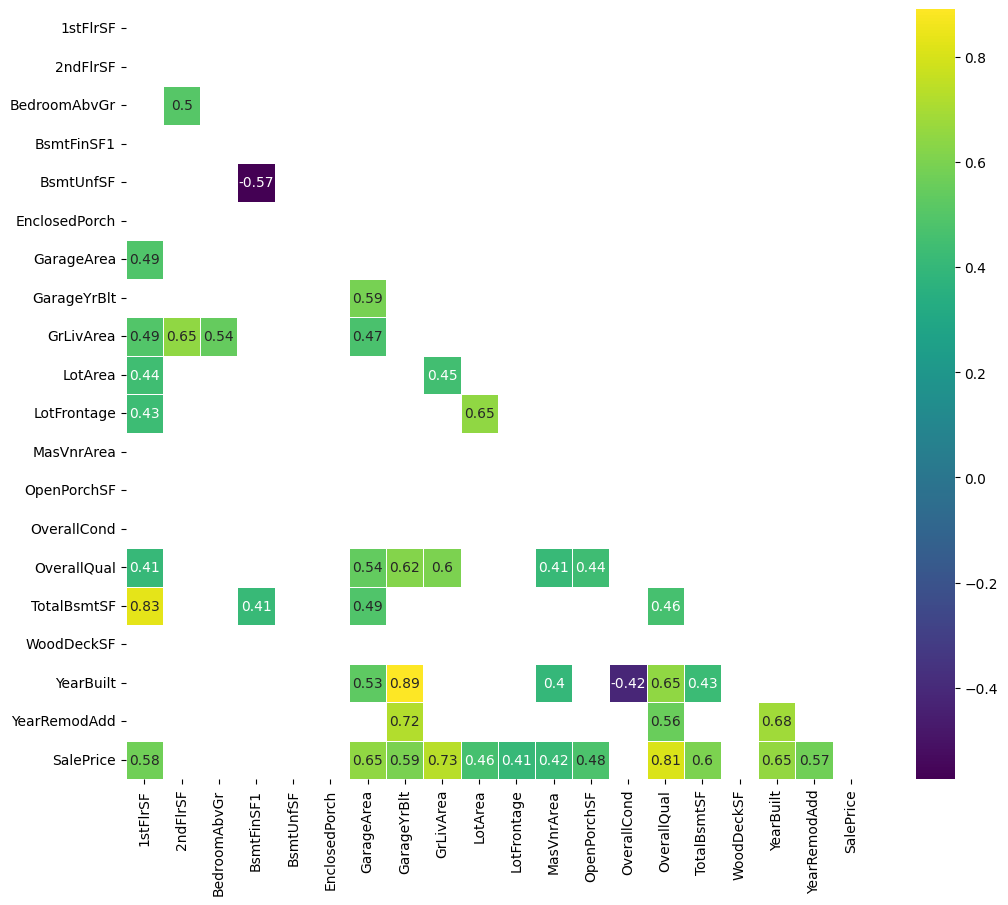



*** Heatmap: Pearson Correlation ***
It evaluates the linear relationship between two continuous variables 



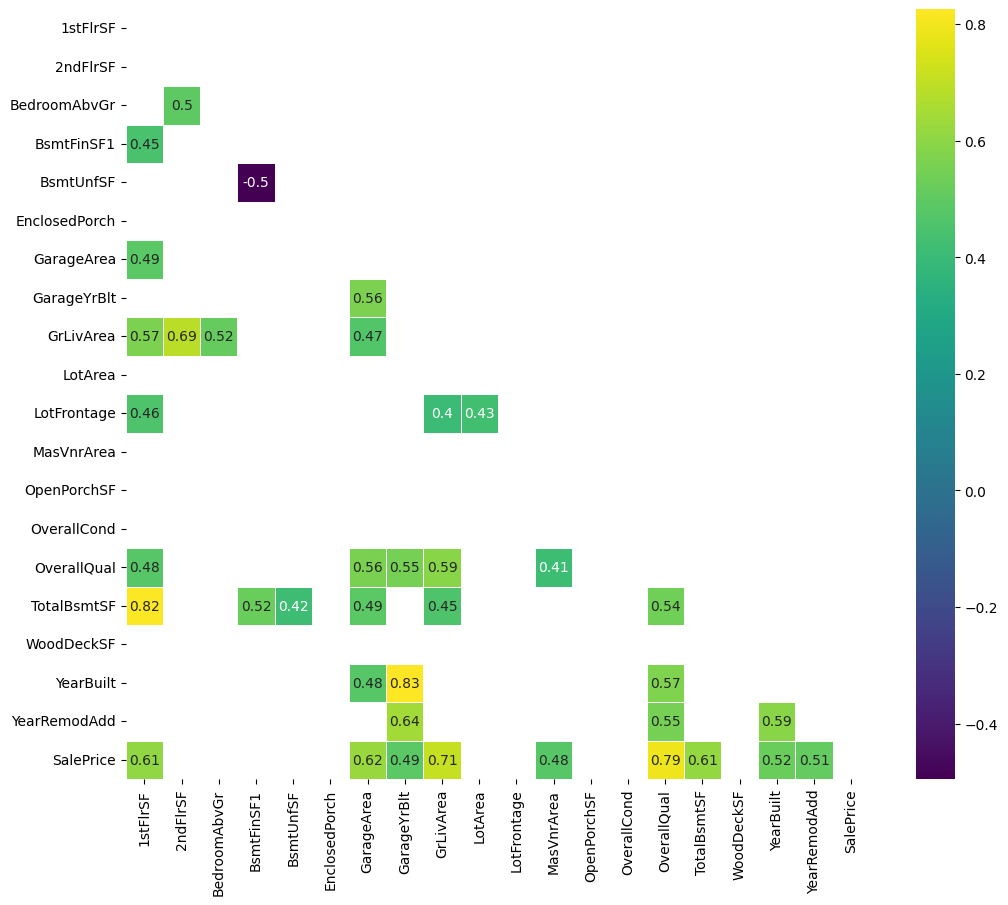



*** Heatmap: Power Predictive Score (PPS) ***
PPS detects linear or non-linear relationships between two columns.
The score ranges from 0 (no predictive power) to 1 (perfect predictive power) 



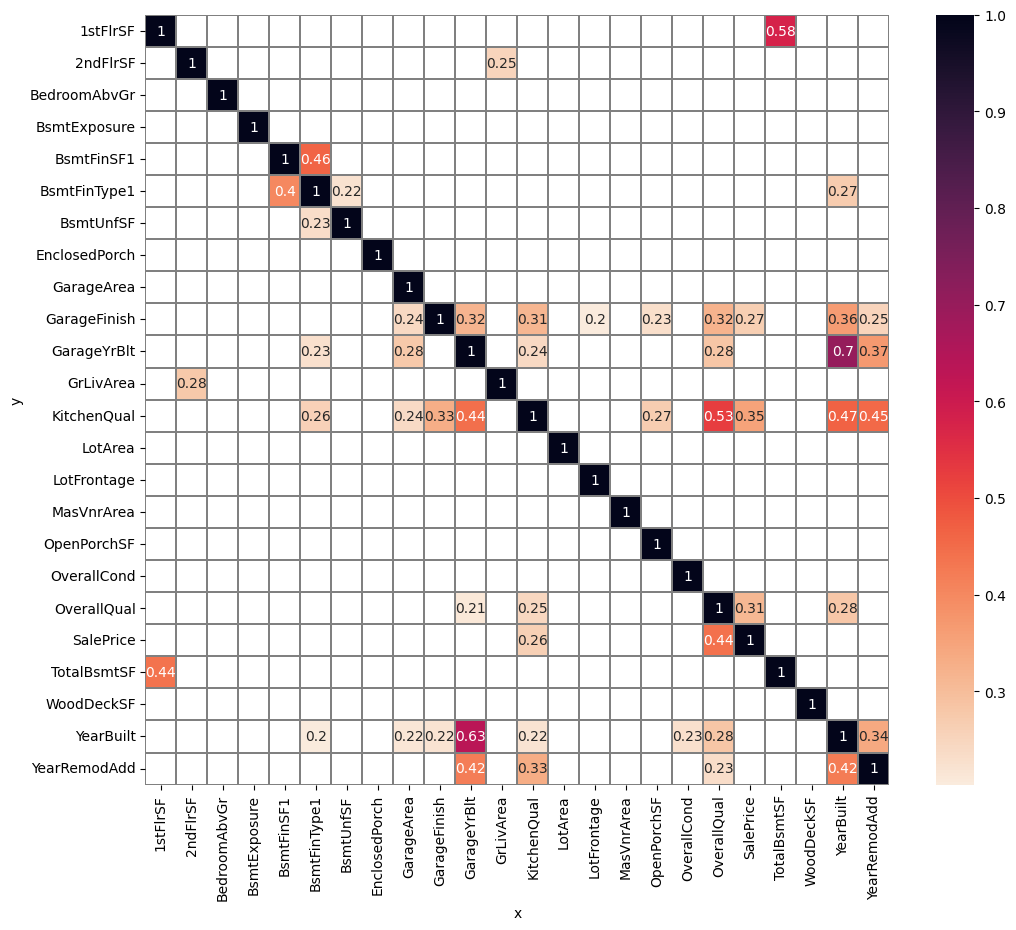

In [7]:
DisplayCorrAndPPS(
    df_corr_pearson=df_corr_pearson,
    df_corr_spearman=df_corr_spearman,
    pps_matrix=pps_matrix,
    CorrThreshold=0.4,
    PPS_Threshold=0.2,
    figsize=(12, 10),
    font_annot=10,
)

---

## Data Cleaning

Assessing Missing Data Levels

- Custom function to display missing data levels in a DataFrame, it shows the absolute levels, relative levels and data type.

In [8]:
def EvaluateMissingData(df):
    """
    Function to evaluate data with missing values, including most frequent value (mode).
    """
    missing_data_absolute = df.isnull().sum()
    missing_data_percentage = round(missing_data_absolute / len(df) * 100, 2)

    most_frequent_values = df.apply(
        lambda col: (
            col.mode(dropna=True)[0] if not col.mode(dropna=True).empty else "No mode"
        )
    )

    df_missing_data = (
        pd.DataFrame(
            data={
                "RowsWithMissingData": missing_data_absolute,
                "PercentageOfDataset": missing_data_percentage,
                "DataType": df.dtypes,
                "MostFrequentValue": most_frequent_values,
            }
        )
        .sort_values(by=["PercentageOfDataset"], ascending=False)
        .query("PercentageOfDataset > 0")
    )

    return df_missing_data

In [ ]:
EvaluateMissingData(df)

### Missing Data Evaluation
Our goal is to keep as much useful data as possible, while dealing with missing values properly. We looked at each column with missing values and decided whether to drop it or fill it in.

**Columns to Drop**
These columns are missing too many values, and they don't seem very helpful for predicting the house price. So we will drop them.

| Column          | Missing % | Reason                                  |
|-----------------|-----------|------------------------------------------|
| EnclosedPorch   | 90.68%    | Too many missing values, not very useful |
| WoodDeckSF      | 89.38%    | Also many missing values, not so helpful |


**Columns to Impute**
These columns are more useful, and the missing values can be filled in with simple methods like the most common value or the average/median.
Findings:

| Column          | Missing % | Fill With        | Reason |
|-----------------|-----------|------------------|--------|
| LotFrontage     | 17.74%    | Median           | Good for numbers like this |
| GarageFinish    | 16.10%    | 'unf' (unfinished) | Most common value |
| BsmtFinType1    | 9.93%     | 'unf'            | Most common value |
| BedroomAbvGr    | 6.78%     | Median           | Safe and simple |
| 2ndFlrSF        | 5.89%     | 0                | Most houses have no 2nd floor |
| GarageYrBlt     | 5.55%     | Median           | Close to house build year |
| BsmtExposure    | 2.60%     | 'no'             | Most common value |
| MasVnrArea      | 0.55%     | 0                | Most houses have 0 here |



## Drop Unnecessary Variables

In order to assess the effect of dropped data for each of the imputations we are about to make, we use CI's custom code:

In [9]:
def DataCleaningEffect(df_original, df_cleaned, variables_applied_with_method):
    flag_count = 1  # Indicate plot number

    # Identify categorical variables
    categorical_variables = df_original.select_dtypes(exclude=["number"]).columns

    for set_of_variables in [variables_applied_with_method]:
        print(
            "\n====================================================================================="
        )
        print(
            f"* Distribution Effect Analysis After Data Cleaning Method in the following variables:"
        )
        print(f"{set_of_variables} \n\n")

        for var in set_of_variables:
            if var in categorical_variables:
                df1 = pd.DataFrame({
                    "Type": "Original",
                    "Value": df_original[var].astype(str).reset_index(drop=True)
                })
                df2 = pd.DataFrame({
                    "Type": "Cleaned",
                    "Value": df_cleaned[var].astype(str).reset_index(drop=True)
                })
                dfAux = pd.concat([df1, df2], axis=0)

                fig, axes = plt.subplots(figsize=(15, 5))
                sns.countplot(
                    hue="Type", data=dfAux, x="Value", palette=["#432371", "#FAAE7B"]
                )
                axes.set(title=f"Distribution Plot {flag_count}: {var}")
                plt.xticks(rotation=90)
                plt.legend()

            else:
                fig, axes = plt.subplots(figsize=(10, 5))
                sns.histplot(
                    data=df_original,
                    x=var,
                    color="#432371",
                    label="Original",
                    kde=True,
                    element="step",
                    ax=axes,
                )
                sns.histplot(
                    data=df_cleaned,
                    x=var,
                    color="#FAAE7B",
                    label="Cleaned",
                    kde=True,
                    element="step",
                    ax=axes,
                )
                axes.set(title=f"Distribution Plot {flag_count}: {var}")
                plt.legend()

            plt.show()
            flag_count += 1


In [10]:
from feature_engine.selection import DropFeatures

variables_method = ["EnclosedPorch", "WoodDeckSF"]
variables_method

imputer = DropFeatures(features_to_drop=variables_method)
df_method = imputer.fit_transform(df)
df_method.head(5)

,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtExposure,BsmtFinSF1,BsmtFinType1,BsmtUnfSF,GarageArea,GarageFinish,GarageYrBlt,...,LotArea,LotFrontage,MasVnrArea,OpenPorchSF,OverallCond,OverallQual,TotalBsmtSF,YearBuilt,YearRemodAdd,SalePrice
0,856,854.0,3.0,No,706,GLQ,150,548,RFn,2003.0,...,8450,65.0,196.0,61,5,7,856,2003,2003,208500
1,1262,0.0,3.0,Gd,978,ALQ,284,460,RFn,1976.0,...,9600,80.0,0.0,0,8,6,1262,1976,1976,181500
2,920,866.0,3.0,Mn,486,GLQ,434,608,RFn,2001.0,...,11250,68.0,162.0,42,5,7,920,2001,2002,223500
3,961,NaN,NaN,No,216,ALQ,540,642,Unf,1998.0,...,9550,60.0,0.0,35,5,7,756,1915,1970,140000
4,1145,NaN,4.0,Av,655,GLQ,490,836,RFn,2000.0,...,14260,84.0,350.0,84,5,8,1145,2000,2000,250000


- Now there are only 22 columns, which means two columns were successfully dropped.

## Impute Variables (handle missing data)

### Arbitrary Number Imputation

- The number '0' shall be imputed for 2ndFlrSF and MasVnrArea


* Distribution Effect Analysis After Data Cleaning Method in the following variables:
['2ndFlrSF', 'MasVnrArea'] 




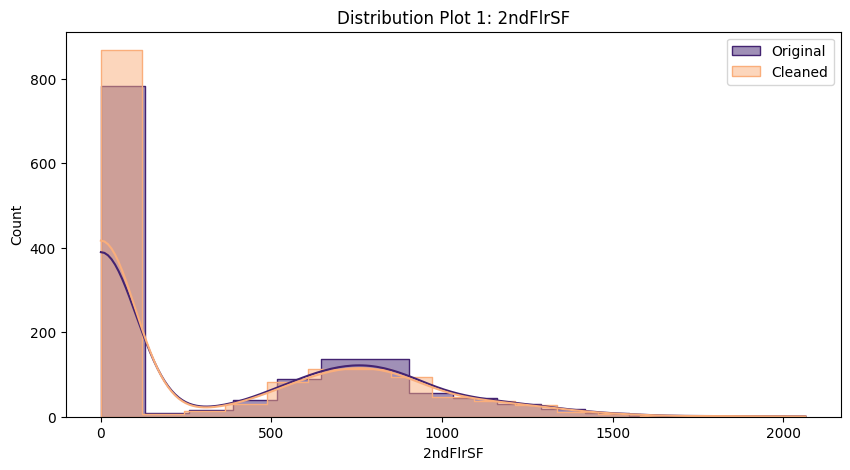

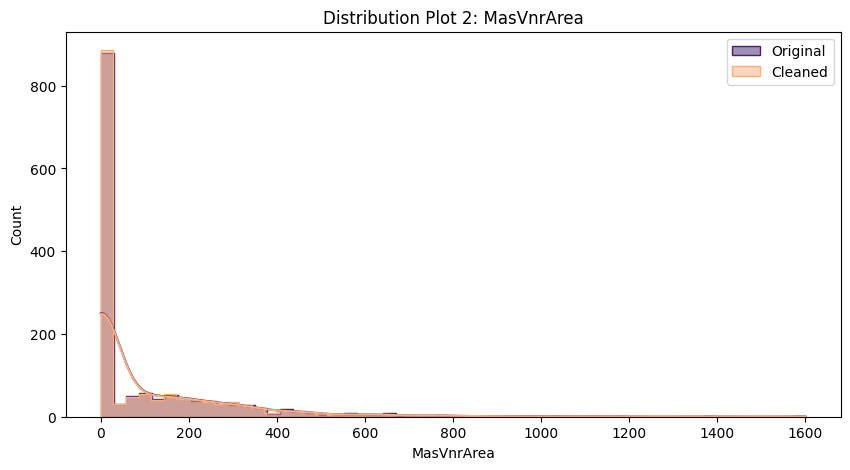

In [11]:
from feature_engine.imputation import ArbitraryNumberImputer

variables_method = ["2ndFlrSF", "MasVnrArea"]

imputer = ArbitraryNumberImputer(arbitrary_number=0, variables=variables_method)
df_method = imputer.fit_transform(df_method)

DataCleaningEffect(
    df_original=df, df_cleaned=df_method, variables_applied_with_method=variables_method
)


We can see that the cleaned data has a similar distribution to the original data, indicating no major distortion by the cleaning.

### Median Imputation

The median shall be imputed for LotFrontage, BedroomAbvGr and GarageYrBlt.


* Distribution Effect Analysis After Data Cleaning Method in the following variables:
['LotFrontage', 'BedroomAbvGr', 'GarageYrBlt'] 




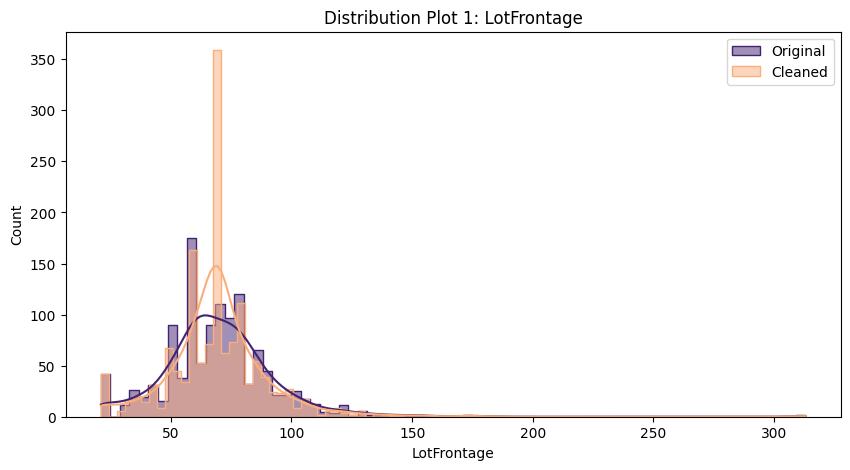

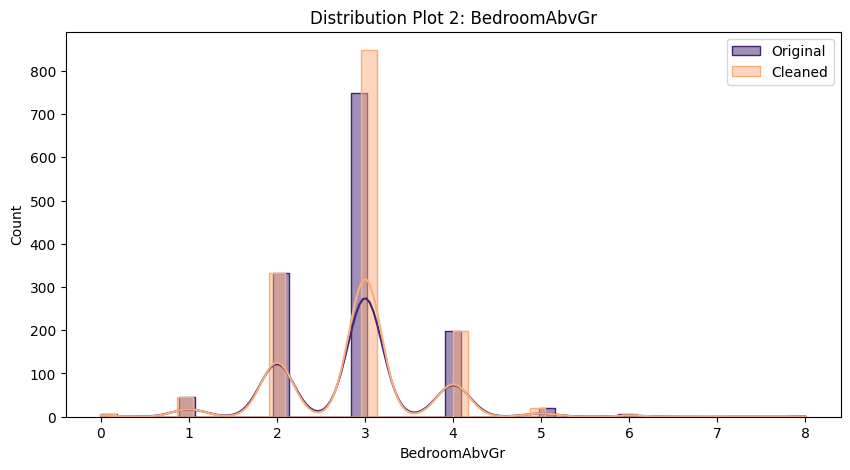

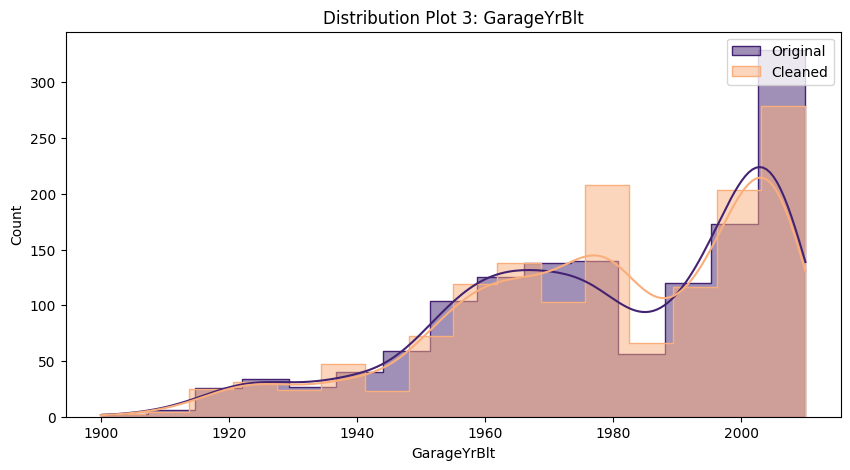

In [12]:
from feature_engine.imputation import MeanMedianImputer

variables_method = ["LotFrontage", "BedroomAbvGr", "GarageYrBlt"]

imputer = MeanMedianImputer(imputation_method="median", variables=variables_method)
df_method = imputer.fit_transform(df_method)

DataCleaningEffect(
    df_original=df, df_cleaned=df_method, variables_applied_with_method=variables_method
)


While the distributions of the cleaned data are not identical to the original, they remain fairly consistent overall. Since the visual comparison shows no significant distortion, we consider the cleaning process appropriate.

### Categorical Imputation

- The value 'Unf', due to being the most common one, shall be imputed for BsmtFinType1 and GarageFinish.


* Distribution Effect Analysis After Data Cleaning Method in the following variables:
['BsmtFinType1', 'GarageFinish'] 




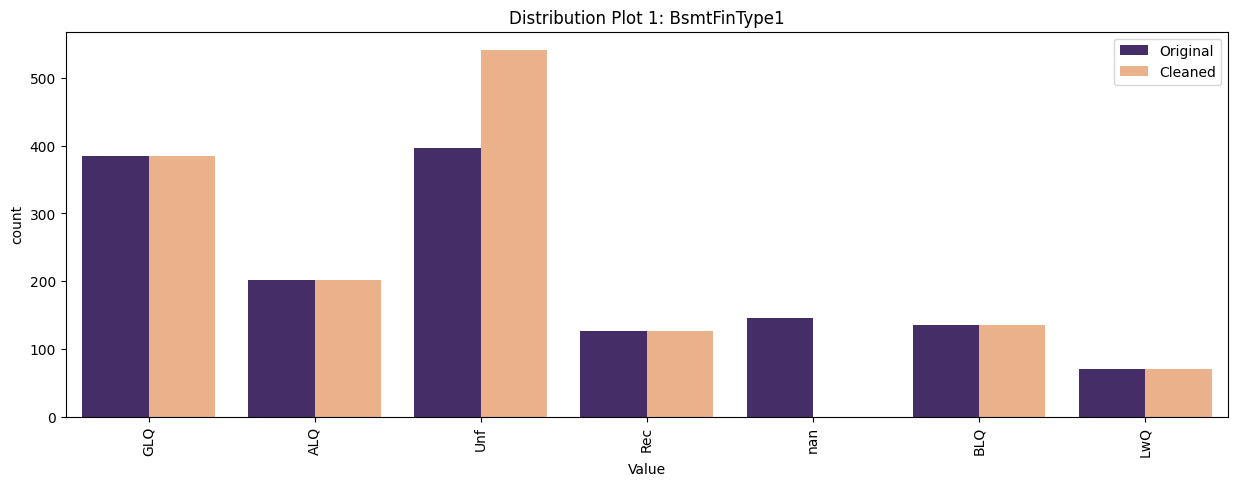

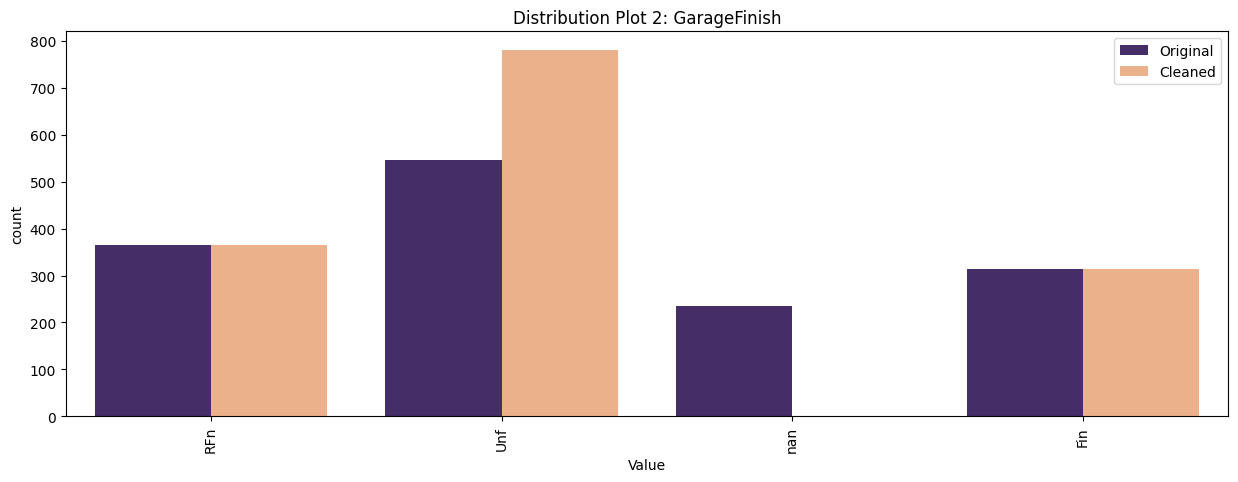

In [13]:
from feature_engine.imputation import CategoricalImputer

variables_method = ["BsmtFinType1", "GarageFinish"]

imputer = CategoricalImputer(
    imputation_method="missing", fill_value="Unf", variables=variables_method
)
df_method = imputer.fit_transform(df_method)

DataCleaningEffect(
    df_original=df, df_cleaned=df_method, variables_applied_with_method=variables_method
)


As expected, the cleaned data shows more values of 'Unf', which is what the imputation was supposed to achieve.

The value 'No', due to being the most common one, shall be imputed for BsmtExposure.


* Distribution Effect Analysis After Data Cleaning Method in the following variables:
['BsmtExposure'] 




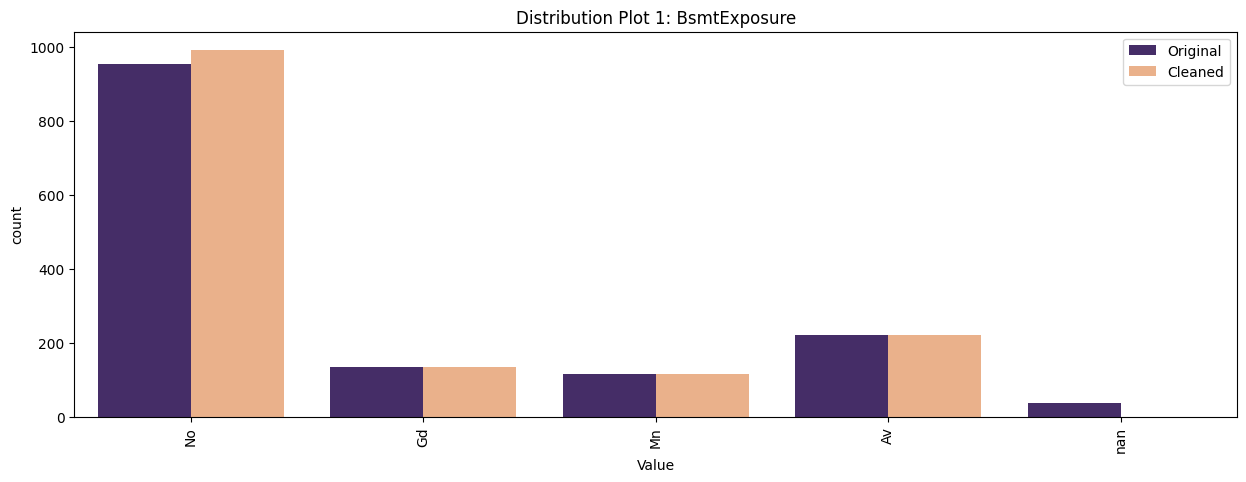

In [14]:
from feature_engine.imputation import CategoricalImputer

variables_method = ["BsmtExposure"]

imputer = CategoricalImputer(
    imputation_method="missing", fill_value="No", variables=variables_method
)
df_method = imputer.fit_transform(df_method)  # <- this is the key fix!

DataCleaningEffect(
    df_original=df,  # <- this can stay as df, to compare against original
    df_cleaned=df_method,
    variables_applied_with_method=variables_method
)


## Split Train and Test Set

In [15]:
from sklearn.model_selection import train_test_split

# Separate features and target
X = df_method.drop(columns=["SalePrice"])
y = df_method["SalePrice"]

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=0
)

print(f"X_train shape: {X_train.shape} \nX_test shape: {X_test.shape}")


X_train shape: (1168, 21) 
X_test shape: (292, 21)


- These cleaned datasets can now be used for Feature Engineering or Modeling

---

## Data Cleaning Pipeline

Apply the pipeline to the whole dataset to get cleaned data.

In [16]:
from sklearn.pipeline import Pipeline
from feature_engine.imputation import (
    MeanMedianImputer,
    ArbitraryNumberImputer,
    CategoricalImputer,
)

cleaning_pipeline = Pipeline(
    steps=[
        (
            "median_imputer",
            MeanMedianImputer(
                imputation_method="median",
                variables=["LotFrontage", "GarageYrBlt", "BedroomAbvGr"],
            ),
        ),
        (
            "arbitrary_imputer",
            ArbitraryNumberImputer(
                arbitrary_number=0, variables=["2ndFlrSF", "MasVnrArea"]
            ),
        ),
        (
            "cat_imputer_unf",
            CategoricalImputer(
                imputation_method="missing",
                fill_value="Unf",
                variables=["GarageFinish", "BsmtFinType1"],
            ),
        ),
        (
            "cat_imputer_no",
            CategoricalImputer(
                imputation_method="missing", fill_value="No", variables=["BsmtExposure"]
            ),
        ),
    ]
)

## Apply the Pipeline to Train and Test Sets

In [17]:
# Fit the pipeline only on training data
cleaning_pipeline.fit(X_train)

# Transform both train and test sets
X_train_cleaned = cleaning_pipeline.transform(X_train)
X_test_cleaned = cleaning_pipeline.transform(X_test)

# Optional: combine with target
TrainSetCleaned = X_train_cleaned.copy()
TrainSetCleaned["SalePrice"] = y_train.values

TestSetCleaned = X_test_cleaned.copy()
TestSetCleaned["SalePrice"] = y_test.values

FullCleaned = pd.concat([TrainSetCleaned, TestSetCleaned], axis=0)

---

## Save Cleaned Data and Pipeline

In [18]:
import os
import joblib

# Create output folders
os.makedirs("outputs/datasets/cleaned", exist_ok=True)
os.makedirs("outputs/ml_pipeline/data_cleaning", exist_ok=True)

# Save cleaned data
TrainSetCleaned.to_csv("outputs/datasets/cleaned/TrainSetCleaned.csv", index=False)
TestSetCleaned.to_csv("outputs/datasets/cleaned/TestSetCleaned.csv", index=False)
FullCleaned.to_csv("outputs/datasets/cleaned/HousePricesCleaned.csv", index=False)

# Save pipeline
joblib.dump(
    cleaning_pipeline, "outputs/ml_pipeline/data_cleaning/dataCleaning_pipeline.pkl"
)

['outputs/ml_pipeline/data_cleaning/dataCleaning_pipeline.pkl']

---

## Summary and Next Steps

**Summary**

- Assessed and handled missing values:
    - Median imputation: variables = ['LotFrontage', 'GarageYrBlt', 'BedroomAbvGr']
    - Arbitrary (0) imputation: variables = ['2ndFlrSF', 'MasVnrArea']
    - Categorical imputation (most frequent):
        - fill_value='Unf': variables = ['GarageFinish', 'BsmtFinType1']
        - fill_value='No' : variables = ['BsmtExposure']
    - Dropped variables: features_to_drop = ['EnclosedPorch', 'WoodDeckSF']
- Split dataset into training and test sets
- Built a cleaning pipeline for future reuse
- Cleaned data saved to `outputs/datasets/cleaned/`
- Data cleaning pipeline saved to `outputs/ml_pipeline/data_cleaning/`

**Next Steps**:

Move to Data Study (EDA) Notebook to analyze feature–target relationships and generate visual insights for the dashboard.